# 1. Load Libraries

In [1]:
import numpy as np
import pandas as pd
import keras
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch.optim as optim
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import warnings
warnings.simplefilter('ignore')
import glob
from keras.layers import AveragePooling2D,GlobalAveragePooling2D,MaxPooling2D,MaxPool2D,Dropout
from keras.models import Model,Sequential


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Load Data

In [3]:
df_train = pd.read_csv('sign_mnist_train.csv')
df_test = pd.read_csv('sign_mnist_test.csv')

print(df_train.shape)
print(df_test.shape)
df_train.head()
img_label = {
    0:'A' , 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I',10:'K',11:'L',12:'M',
    13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y'
}

(27455, 785)
(7172, 785)


Data Transform and Normalize

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_images = []
train_labels = []

# Iterate through the DataFrame and apply transforms to each image
for index, row in df_train.iterrows():
    # Extract pixel data and reshape it to a 2D array
    image_data = row.drop('label').values.reshape(28, 28)
    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(image_data.astype(np.uint8))
    # Apply transformations
    transformed_image = train_transform(image)
    # Append the transformed image and label to the lists
    train_images.append(transformed_image)
    train_labels.append(row['label'])

# Create a list to store transformed images for testing
test_images = []
test_labels = []

# Iterate through the DataFrame and apply transforms to each image
for index, row in df_test.iterrows():
    # Extract pixel data and reshape it to a 2D array
    image_data = row.drop('label').values.reshape(28, 28)
    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(image_data.astype(np.uint8))
    # Apply transformations
    transformed_image = test_transform(image)
    # Append the transformed image and label to the lists
    test_images.append(transformed_image)
    test_labels.append(row['label'])


In [5]:
train_dataset = TensorDataset(torch.stack(train_images), torch.tensor(train_labels))

In [6]:
dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

test_dataset = TensorDataset(torch.stack(test_images), torch.tensor(test_labels))

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle = False)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle = False)

Hand gesture exmaples show

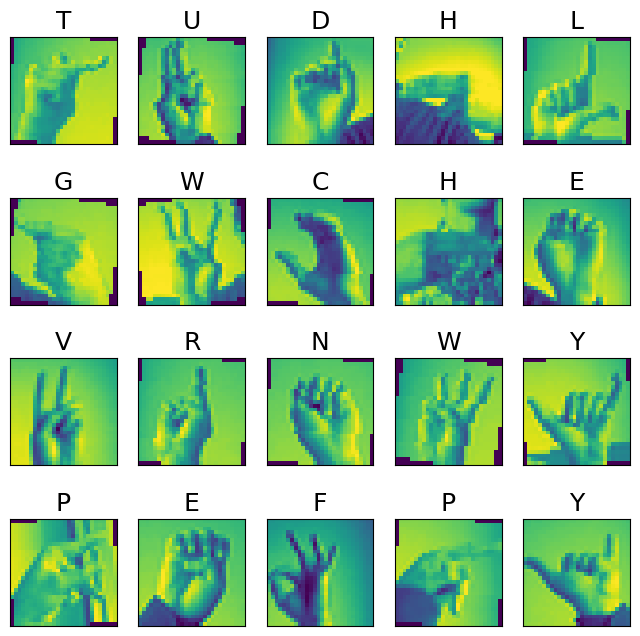

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(img_label[labels[idx].item()], fontsize = 18)
plt.show()

# 3.Define Network

In [9]:
def matrix_plot(actual, predictions):
    # Access the letter labels directly using list comprehensions
    actual_labels_mapped = [img_label[label] for label in actual_labels]
    predictions_mapped = [img_label[label] for label in predictions]

    # Now create the confusion matrix
    cm = confusion_matrix(actual_labels_mapped, predictions_mapped)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Calculate percentage

    plt.figure(figsize=(18, 12))
    sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap='viridis',
                xticklabels=list(img_label.values()),
                yticklabels=list(img_label.values()),
                annot_kws={"size": 10},
                cbar_kws={'format': '%.0f%%'})
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix")
    plt.yticks(rotation=0)
    plt.show()

In [10]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate, weight_decay = 0):
    train_acc = []
    valid_acc = []
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        tot_train_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        # trainloader
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tot_train_loss += loss.item()
            # Calculate accuracy
            _, predicted_labels = torch.max(outputs, 1)  # Get predicted labels
            correct_predictions += (predicted_labels == labels).sum().item()  # Count correct predictions
            total_samples += labels.size(0)  # Count total samples

            # Calculate and print accuracy for the epoch
        epoch_accuracy = 100 * correct_predictions / total_samples

        # validloader
        with torch.no_grad():
            model.eval()
            tot_valid_loss = 0.0
            correct_predictions_val = 0
            total_samples_val = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.type(torch.LongTensor).to(device)

                outputs = model(images)
                # Calculate accuracy
                _, predicted_labels_val = torch.max(outputs, 1)
                correct_predictions_val += (predicted_labels_val == labels).sum().item()
                total_samples_val += labels.size(0)
            epoch_accuracy_val = 100 * correct_predictions_val / total_samples_val
        train_acc.append(epoch_accuracy)
        valid_acc.append(epoch_accuracy_val)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {tot_train_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%, Accuravy_val: {epoch_accuracy_val: 2f}%')
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted_labels = torch.max(outputs, 1)

            predictions.extend(predicted_labels.cpu().numpy())
        actual_labels = test_dataset.tensors[1].cpu().numpy()
        comparison = predictions == test_labels
        accuracy = accuracy_score(actual_labels, predictions)
        print(f"Test Accuracy: {accuracy}")
    return train_acc, valid_acc, predictions, actual_labels

### 1) Logistic Regreesion Model using mutiple layer(Baseline Model)



In [14]:
# Define the logistic regression model as baseline
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.2):
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])

        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])

        self.output = nn.Linear(hidden_layers[-1], output_size)

        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)

        return x

In [ ]:
# Hyperparameters
input_size = 784  # 28x28 images
output_size = 25
num_epochs = 30
learning_rate = 0.001
weight_decay = 0.0001

# Initialize the model, loss function, and optimizer
log_model = LogisticRegression(input_size, output_size, [256, 128, 64]).to(device)
train_acc, valid_acc, predictions, actual_labels  = train(log_model, train_loader, valid_loader, num_epochs, learning_rate, weight_decay)

Epoch [1/30], Loss: 2.6732, Accuracy: 18.55%, Accuravy_val:  37.703436%
Epoch [2/30], Loss: 1.8405, Accuracy: 39.78%, Accuravy_val:  51.265823%
Epoch [3/30], Loss: 1.4510, Accuracy: 50.51%, Accuravy_val:  60.488246%
Epoch [4/30], Loss: 1.2010, Accuracy: 59.78%, Accuravy_val:  67.721519%
Epoch [5/30], Loss: 1.0175, Accuracy: 65.13%, Accuravy_val:  73.417722%
Epoch [6/30], Loss: 0.8873, Accuracy: 69.15%, Accuravy_val:  76.627486%
Epoch [7/30], Loss: 0.7721, Accuracy: 73.41%, Accuravy_val:  80.153707%
Epoch [8/30], Loss: 0.6866, Accuracy: 76.24%, Accuravy_val:  83.227848%
Epoch [9/30], Loss: 0.6126, Accuracy: 78.60%, Accuravy_val:  82.775769%
Epoch [10/30], Loss: 0.5654, Accuracy: 80.48%, Accuravy_val:  83.318264%
Epoch [11/30], Loss: 0.5278, Accuracy: 82.20%, Accuravy_val:  86.618445%
Epoch [12/30], Loss: 0.4654, Accuracy: 83.81%, Accuravy_val:  87.748644%
Epoch [13/30], Loss: 0.4236, Accuracy: 85.32%, Accuravy_val:  87.974684%
Epoch [14/30], Loss: 0.4088, Accuracy: 85.94%, Accuravy_val:

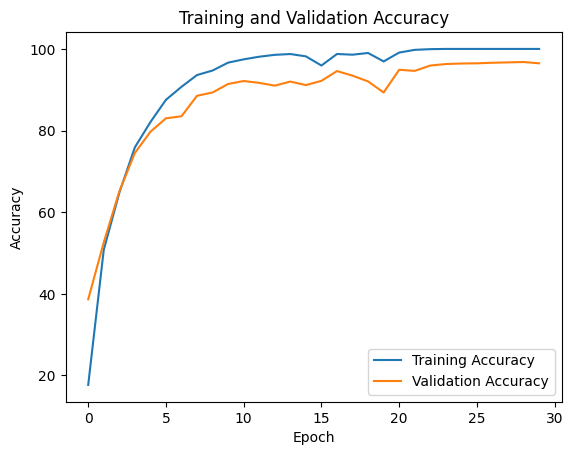

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

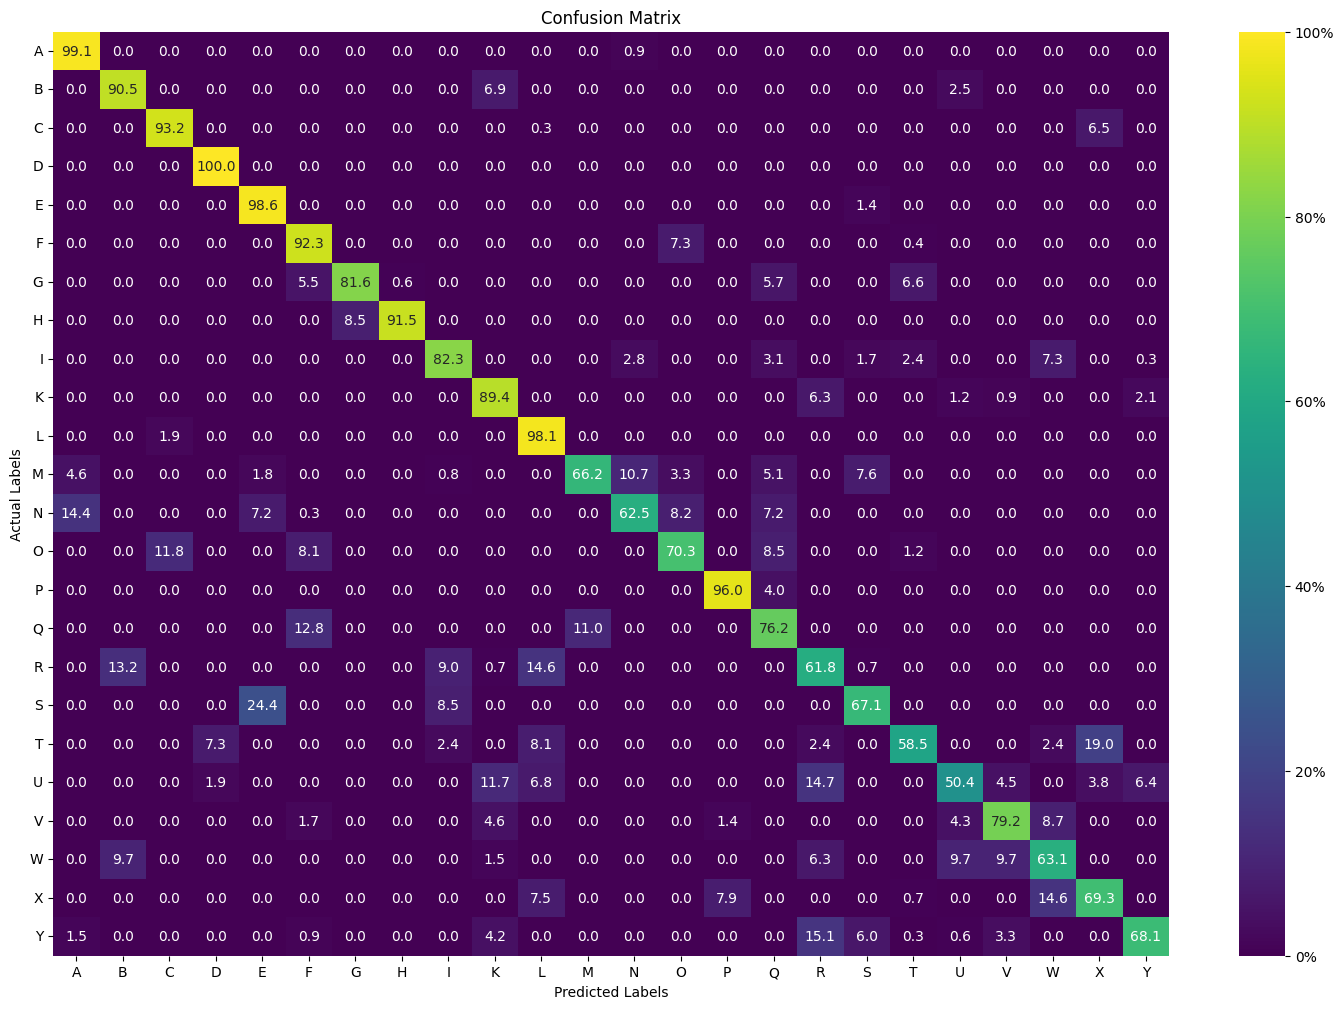

In [ ]:
classification_report(actual_labels, predictions)
matrix_plot(actual_labels, predictions)

### 2) CNN Model

In [25]:
class CNN(nn.Module):
    def __init__(self, num_classes=25):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 128, 128)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 7 * 7 * 128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class OptimizedCNN(nn.Module):
    def __init__(self, num_classes=25):
        super(OptimizedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


# Initialize the CNN model
cnn_model = OptimizedCNN().to(device)

# Hyperparameters
num_epochs = 70
learning_rate = 0.00008
weight_decay = 1e-12

# Initialize the model, loss function, and optimizer
train_acc, valid_acc, predictions, actual_labels = train(cnn_model, train_loader, valid_loader, num_epochs, learning_rate, weight_decay)

Epoch [1/70], Loss: 2.8113, Accuracy: 17.21%, Accuravy_val:  52.558732%
Epoch [2/70], Loss: 1.7426, Accuracy: 46.04%, Accuravy_val:  85.357858%
Epoch [3/70], Loss: 1.0755, Accuracy: 65.89%, Accuravy_val:  91.495174%
Epoch [4/70], Loss: 0.7103, Accuracy: 77.71%, Accuravy_val:  95.556365%
Epoch [5/70], Loss: 0.4851, Accuracy: 85.46%, Accuravy_val:  97.723548%
Epoch [6/70], Loss: 0.3525, Accuracy: 89.90%, Accuravy_val:  98.433801%
Epoch [7/70], Loss: 0.2589, Accuracy: 92.84%, Accuravy_val:  98.433801%
Epoch [8/70], Loss: 0.1979, Accuracy: 94.64%, Accuravy_val:  99.235112%
Epoch [9/70], Loss: 0.1507, Accuracy: 96.16%, Accuravy_val:  99.653979%
Epoch [10/70], Loss: 0.1228, Accuracy: 96.82%, Accuravy_val:  99.362593%
Epoch [11/70], Loss: 0.1026, Accuracy: 97.35%, Accuravy_val:  99.708614%
Epoch [12/70], Loss: 0.0857, Accuracy: 97.99%, Accuravy_val:  99.817884%
Epoch [13/70], Loss: 0.0745, Accuracy: 98.18%, Accuravy_val:  99.562921%
Epoch [14/70], Loss: 0.0637, Accuracy: 98.42%, Accuravy_val:

In [29]:
model_path = 'model.pth'
torch.save(cnn_model.state_dict(), model_path)

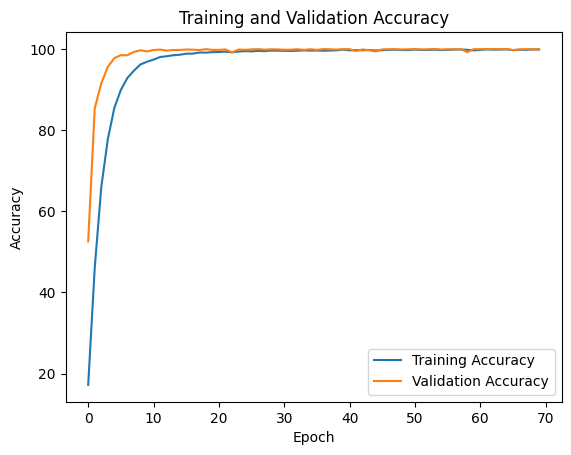

In [26]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

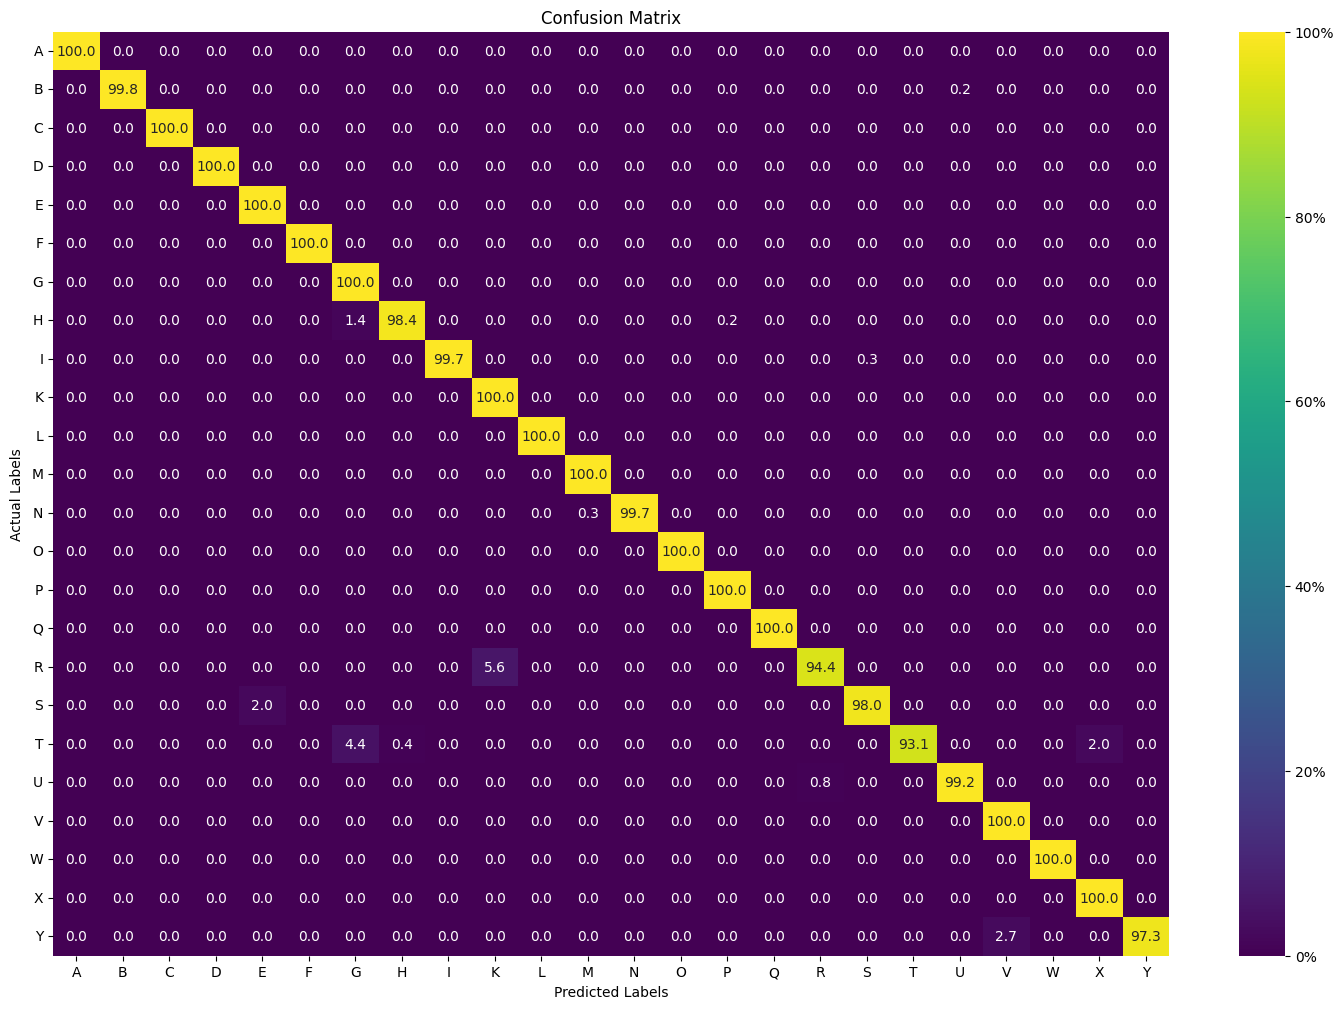

In [27]:
classification_report(actual_labels, predictions)
matrix_plot(actual_labels, predictions)

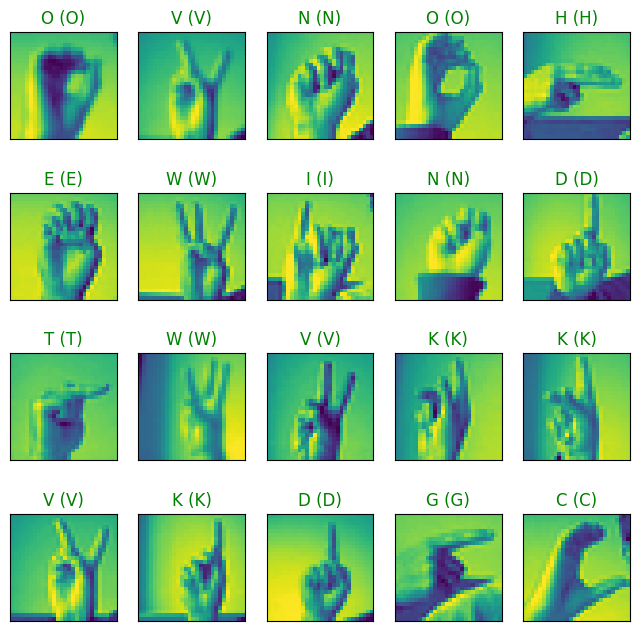

In [28]:
preds = np.squeeze(predictions)
images = next(iter(test_loader))[0]
images = images.numpy()
rd = random.sample(range(len(images)), 20)

fig = plt.figure(figsize=(8, 8))
for i, idx in enumerate(rd):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(img_label[preds[idx]], img_label[actual_labels[idx]]),
                 color=("green" if preds[idx]==actual_labels[idx].item() else "red"))
plt.show()